This notebook is used to make Figure 6 of the manuscript: maps of EMD diagnostic comparing climatology of model to climatology of satellite.

The EMD diagnostic itself is calculated separately and stored as a netCDF file. 
*That calculation is done with `compute_save_emd.py`*

Note that other distances or divergences have been used along the way to settling on EMD. The main one I experimented with was relative entropy, aka Kullback-Liebler divergence.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
import numpy as np
import xarray as xr
import cmasher as cm
import colorcet as cc
from pathlib import Path

import computations as comp  # lonFlip

In [2]:
# files, just
# 
# 
stem = Path('/Users/brianpm/Dropbox/Projects/COSP2/') 

# Kullback-Liebler
# c4_misr = xr.open_dataset(stem / 'cam4_misr_histogram_error_c20221121.nc')
# c5_misr = xr.open_dataset(stem / 'cam5_misr_histogram_error_c20221121.nc')
# c6_misr = xr.open_dataset(stem / 'cam6_misr_histogram_error_c20221121.nc')

# c4_modis = xr.open_dataset(stem / 'cam4_modis_post2000_histogram_error_c20221121.nc')
# c5_modis = xr.open_dataset(stem / 'cam5_modis_post2000_histogram_error_c20221121.nc')
# c6_modis = xr.open_dataset(stem / 'cam6_modis_post2000_histogram_error_c20221121.nc')

# c4_isccp = xr.open_dataset(stem / 'cam4_isccp_post2000_histogram_error_c20221121.nc')
# c5_isccp = xr.open_dataset(stem / 'cam5_isccp_post2000_histogram_error_c20221121.nc')
# c6_isccp = xr.open_dataset(stem / 'cam6_isccp_post2000_histogram_error_c20221121.nc')
# e3_isccp = xr.open_dataset(stem / 'e3sm_isccp_post2000_histogram_error_c20221121.nc')

# Earth Mover's Distance
c4_misr = xr.open_dataset(stem / 'cam4_misr_2001-2020_emd_nanversion.nc')
c5_misr = xr.open_dataset(stem / 'cam5_misr_2001-2020_emd_nanversion.nc')
c6_misr = xr.open_dataset(stem / 'cam6_misr_2001-2020_emd_nanversion.nc')

c4_modis = xr.open_dataset(stem / 'cam4_modis_2002-2022_emd_nanversion.nc')
c5_modis = xr.open_dataset(stem / 'cam5_modis_2002-2022_emd_nanversion.nc')
c6_modis = xr.open_dataset(stem / 'cam6_modis_2002-2022_emd_nanversion.nc')

c4_isccp = xr.open_dataset(stem / 'cam4_isccp_2000-2016_emd_nanversion.nc')
c5_isccp = xr.open_dataset(stem / 'cam5_isccp_2000-2016_emd_nanversion.nc')
c6_isccp = xr.open_dataset(stem / 'cam6_isccp_2000-2016_emd_nanversion.nc')
e3_isccp = xr.open_dataset(stem / 'e3sm_isccp_2000-2016_emd_nanversion.nc')



In [20]:
def add_plot(ax, dset, varname, add_cyclic=False, color_land=False, **kwargs):
    print(f"{np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = }")
    # Order of operations may matter... DEAL WITH CYCLIC FIRST, THEN FLIP.
    if dset['lon'].max() > 180:
        dset = comp.lonFlip(dset)

    lon_in = dset['lon']
    lon_idx = dset[varname].dims.index("lon")

    if add_cyclic:
        cyc, cyclon = add_cyclic_point(dset[varname], coord=lon_in, axis=lon_idx)
        new_coords = dict(dset[varname].coords)
        new_coords["lon"] = cyclon
        cyc = xr.DataArray(cyc, dims=dset[varname].dims, coords=new_coords, attrs=dset[varname].attrs)
    else:
        cyc, cyclon = dset[varname], dset['lon']
        # cyc2 = dset['frobenius_norm']


    if 'cmap' in kwargs:
        cmap = kwargs.pop('cmap')
        # print(f"Found cmap in kwargs: {cmap}")
    else:
        cmap = cc.cm.fire_r
        print("Defaulting the cmap to fire_r")
    if 'norm' in kwargs:
        cnorm = kwargs.pop('norm')
        # print(f"norm in kwargs: cnorm = {cnorm}")
    else:
        cnorm = None
        print("NO cnorm FOUND!")
    if 'lat_slice' in kwargs:
        lat_slice = kwargs.pop('lat_slice')
    else:
        lat_slice = slice(-90,90)
    lons, lats = np.meshgrid(cyc['lon'], dset['lat'])
    img = ax.pcolormesh(lons, lats, cyc, transform=ccrs.PlateCarree(), norm=cnorm, cmap=cmap, **kwargs)
    # ax.contour(lons, lats, cyc2, transform=ccrs.PlateCarree(), colors='grey')
    ax.set_global()
    if color_land:
        ax.add_feature(cf.LAND, zorder=1000)
    # Add global mean annotation:
    # Use lat_slice to reduce to sub-global region
    gavg = dset[varname].sel(lat=lat_slice).weighted(np.cos(np.radians(dset['lat'].sel(lat=lat_slice)))).mean(dim=("lat","lon"))
    ax.text(0.85, 0.95, f"{gavg.item():3.2f}", fontsize=12, ha='left', transform=ax.transAxes, color='gray')
    # draw lines to indicate regional averaging:
    if lat_slice.start != -90:
        ax.plot([0,360], [lat_slice.start, lat_slice.start], transform=ccrs.PlateCarree(), color='gray')
    if lat_slice.stop != 90:
        ax.plot([0,360], [lat_slice.stop, lat_slice.stop], transform=ccrs.PlateCarree(), color='gray')
    return img


np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = array([nan, nan, nan])
np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = array([0.86602674, 1.12360238, 1.7906973 ])
np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = array([nan, nan, nan])
np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = array([nan, nan, nan])
np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = array([0.6112176 , 0.86554284, 2.31877457])
np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = array([nan, nan, nan])
np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = array([nan, nan, nan])
np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = array([0.61828824, 0.7963798 , 1.76583236])
np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = array([nan, nan, nan])
np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = array([nan, nan, nan])


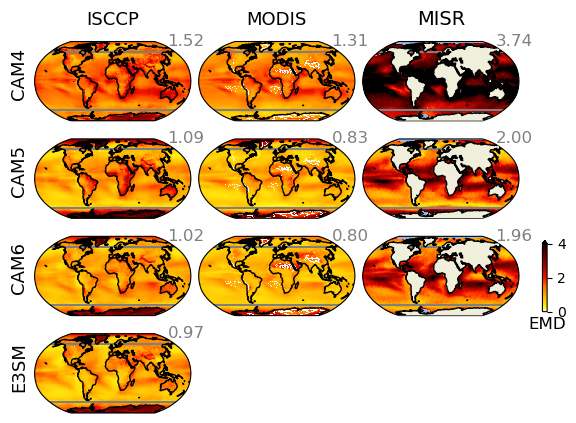

In [21]:
#
# Histogram Error Metric (set to 'relative_entropy' or 'EMD')
#
metric_name = 'EMD'
metric_string = 'EMD' # "$\mathcal{D}_{\mathrm{KL}}$"
proj = ccrs.Robinson()
fig, axs = plt.subplots(figsize=(6.25,5), ncols=3, nrows=4, subplot_kw={"projection":proj})
a1d = axs.ravel()
[a.coastlines(zorder=1001) for a in a1d]
[a.add_feature(cf.LAND, zorder=0) for a in a1d ]
[a.add_feature(cf.OCEAN, zorder=0) for a in a1d ]

opt = dict(norm = mpl.colors.Normalize(vmin=0, vmax=4), 
           cmap = cc.cm.fire_r, 
           rasterized=True, 
           shading='nearest', 
           zorder=0,
           lat_slice=slice(-60,60))

# cyc, cyclon = add_cyclic_point(c4_misr[metric_name], coord=c4_misr['lon'])
# lons, lats = np.meshgrid(c4_misr['lon'], c4_misr['lat'])

img1 = add_plot(axs[0,0], c4_isccp, metric_name, add_cyclic=True, **opt)
img2 = add_plot(axs[0,1], c4_modis, metric_name, add_cyclic=True, **opt)
img3 = add_plot(axs[0,2], c4_misr,  metric_name, add_cyclic=True, color_land=True, **opt)

img4 = add_plot(axs[1,0], c5_isccp, metric_name, **opt)
img5 = add_plot(axs[1,1], c5_modis, metric_name, add_cyclic=True, **opt)
img6 = add_plot(axs[1,2], c5_misr,  metric_name, add_cyclic=False, color_land=True, **opt)

img7 = add_plot(axs[2,0], c6_isccp, metric_name, **opt)
img8 = add_plot(axs[2,1], c6_modis, metric_name, add_cyclic=True, **opt)
img9 = add_plot(axs[2,2], c6_misr,  metric_name, add_cyclic=True, color_land=True, **opt)

img10 = add_plot(axs[3,0], e3_isccp,  metric_name, add_cyclic=True, color_land=False, **opt)

fig.subplots_adjust(wspace=0.05, hspace=0.05)

cb_c9_ax = inset_axes(axs[2,2],
                   width="3%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.15, 0.05, 1, 1),
                   bbox_transform=axs[2,2].transAxes,
                   borderpad=0
                   )
# cb = fig.colorbar(img9, cax=cb_c9_ax)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=opt['norm'], cmap=opt['cmap']), cax=cb_c9_ax,  extend='max')
# cb.set_label("$\mathcal{D}_{\mathrm{KL}}$", loc='bottom', rotation='horizontal', labelpad=-23, fontsize=13)
cb_c9_ax.text(1., -0.25, metric_string,  fontsize=12, ha='center', transform=cb_c9_ax.transAxes)

pos1 = axs[0,0].get_position().bounds
pos2 = axs[0,1].get_position().bounds
pos3 = axs[0,2].get_position().bounds

ypos1 = pos1
ypos2 = axs[1,0].get_position().bounds
ypos3 = axs[2,0].get_position().bounds
ypos4 = axs[3,0].get_position().bounds

fsize = 13

plt.text(pos1[0]+0.5*pos1[2], 0.9, "ISCCP", ha='center', fontsize=fsize, transform=fig.transFigure)
plt.text(pos2[0]+0.5*pos2[2], 0.9, "MODIS", ha='center', fontsize=fsize, transform=fig.transFigure)
plt.text(pos3[0]+0.5*pos3[2], 0.9, "MISR", fontsize=14, ha='center', transform=fig.transFigure)

plt.text(0.1, ypos1[1]+0.32*ypos1[-1], "CAM4", ha='center', fontsize=fsize, rotation=90, transform=fig.transFigure)
plt.text(0.1, ypos2[1]+0.32*ypos2[-1], "CAM5", ha='center', fontsize=fsize, rotation=90, transform=fig.transFigure)
plt.text(0.1, ypos3[1]+0.32*ypos3[-1], "CAM6", ha='center', fontsize=fsize, rotation=90, transform=fig.transFigure)
plt.text(0.1, ypos4[1]+0.32*ypos4[-1], "E3SM", ha='center', fontsize=fsize, rotation=90, transform=fig.transFigure)

fig.delaxes(axs[3,1])
fig.delaxes(axs[3,2])

fig.savefig(f"/Users/brianpm/Dropbox/Projects/COSP2/combined_{metric_name}_maps.pdf", bbox_inches='tight', dpi=300)


flipped longitude -- MIN: -179.5, MAX: 179.5
<xarray.DataArray 'lon' (lon: 360)>
array([-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5], dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Found cmap in kwargs: <matplotlib.colors.LinearSegmentedColormap object at 0x1868cbd60>
norm in kwargs: cnorm = <matplotlib.colors.Normalize object at 0x186dcbc70>
flipped longitude -- MIN: -179.5, MAX: 179.5
<xarray.DataArray 'lon' (lon: 360)>
array([-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Found cmap in kwargs: <matplotlib.colors.LinearSegmentedColormap object at 0x1868cbd60>
norm in kwargs: cnorm = <matplotlib.colors.Normalize object at 0x186dcbc70>
CYCLIC longitude -- MIN: -179.5, MAX: 180.5, New shape: (120, 361)
Found cmap in kwargs: <matplotlib.colors.LinearSegmentedColormap object at 0x1868cbd60>
norm in kwargs: cnorm = <matplotlib.co

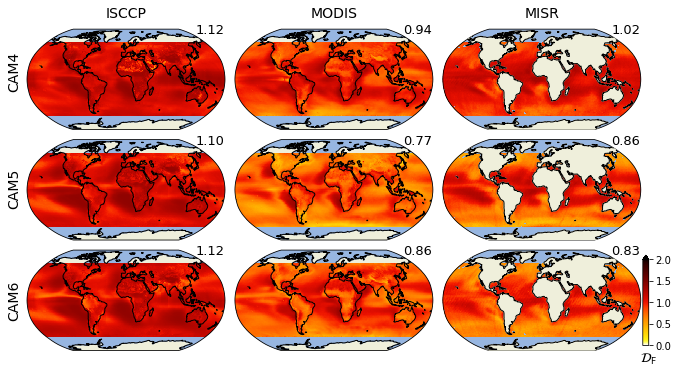

In [12]:
#
# This is the Froebenius Norm version, which is  holdover from experimentation with diffent metrics.
#
proj = ccrs.Robinson()
fig, axs = plt.subplots(figsize=(11,6), ncols=3, nrows=3, subplot_kw={"projection":proj})
a1d = axs.ravel()
[a.coastlines(zorder=1001) for a in a1d]
[a.add_feature(cf.LAND, zorder=0) for a in a1d ]
[a.add_feature(cf.OCEAN, zorder=0) for a in a1d ]
opt = dict(norm = mpl.colors.Normalize(vmin=0, vmax=2), cmap = cc.cm.fire_r, rasterized=True)


img1 = add_plot(axs[0,0], c4_isccp, 'frobenius_norm', **opt)
img2 = add_plot(axs[0,1], c4_modis, 'frobenius_norm', **opt)
img3 = add_plot(axs[0,2], c4_misr, 'frobenius_norm', add_cyclic=True, color_land=True, **opt)

img4 = add_plot(axs[1,0], c5_isccp, 'frobenius_norm', **opt)
img5 = add_plot(axs[1,1], c5_modis, 'frobenius_norm', **opt)
img6 = add_plot(axs[1,2], c5_misr, 'frobenius_norm', add_cyclic=True, color_land=True, **opt)

img7 = add_plot(axs[2,0], c6_isccp, 'frobenius_norm', **opt)
img8 = add_plot(axs[2,1], c6_modis, 'frobenius_norm', **opt)
img9 = add_plot(axs[2,2], c6_misr, 'frobenius_norm', add_cyclic=True, color_land=True, **opt)

fig.subplots_adjust(wspace=0.05, hspace=0.05)

cb_c9_ax = inset_axes(axs[2,2],
                   width="3%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0.05, 1, 1),
                   bbox_transform=axs[2,2].transAxes,
                   borderpad=0
                   )
# cb = fig.colorbar(img9, cax=cb_c9_ax)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=opt['norm'], cmap=opt['cmap']), cax=cb_c9_ax, extend='max')

# cb.set_label("$\mathcal{D}_{\mathrm{KL}}$", loc='bottom', rotation='horizontal', labelpad=-23, fontsize=13)
cb_c9_ax.text(1., -0.2, "$\mathcal{D}_{\mathrm{F}}$",  fontsize=13, ha='center', transform=cb_c9_ax.transAxes)

pos1 = axs[0,0].get_position().bounds
pos2 = axs[0,1].get_position().bounds
pos3 = axs[0,2].get_position().bounds

plt.text(pos1[0]+0.5*pos1[2], 0.9, "ISCCP", ha='center', fontsize=14, transform=fig.transFigure)
plt.text(pos2[0]+0.5*pos2[2], 0.9, "MODIS", ha='center', fontsize=14, transform=fig.transFigure)
plt.text(pos3[0]+0.5*pos3[2], 0.9, "MISR", fontsize=14, ha='center', transform=fig.transFigure)

plt.text(0.1, 0.735, "CAM4", fontsize=14, rotation=90, transform=fig.transFigure)
plt.text(0.1, 0.465, "CAM5", fontsize=14, rotation=90, transform=fig.transFigure)
plt.text(0.1, 0.205, "CAM6", fontsize=14, rotation=90, transform=fig.transFigure)

fig.savefig("/Users/brianpm/Dropbox/Projects/COSP2/combined_frobenius_maps.pdf", bbox_inches='tight', dpi=300)
